In [1]:
import numpy as np
import pandas as pd
import os, random, glob, cv2, gc
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from termcolor import colored

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from albumentations import Compose, Normalize, HorizontalFlip, VerticalFlip, RandomSizedCrop

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

# Data

In [3]:
df = pd.read_csv('train.csv').set_index('image_id')

In [4]:
# shuffle
df = shuffle(df)


# split
train_df, val_df = train_test_split(df, test_size=0.2)
val_df, test_df = train_test_split(val_df, test_size=0.2)

train_df = train_df.reset_index()
val_df = val_df.reset_index()
test_df = test_df.reset_index()

print(len(train_df), len(val_df), len(test_df))

8492 1699 425


In [5]:
train_df.head()

,image_id,data_provider,isup_grade,gleason_score
0,0cbfd6b7a0e0e936db19b032096621ad,radboud,4,4+4
1,50e4e960102369eb7b271d3afe227ef7,karolinska,2,3+4
2,d341e19a76135d79774f19f5e9ecc5a9,radboud,2,3+4
3,a740ac5e9722a89dd2c7afe87b92104a,radboud,0,negative
4,8a2e377920bb4f87e746d837d6ff0f40,karolinska,0,0+0


# Augmentation

In [6]:
mean = [1-0.90949707, 1-0.8188697, 1-0.87795304]
std = [0.36357649, 0.49984502, 0.40477625]
train_transforms = Compose([HorizontalFlip(p=0.5), 
                            VerticalFlip(p=0.5),
                            Normalize(mean, std)])
val_transforms = Compose([Normalize(mean, std)])

# Dataset

In [8]:
class MyDataset(Dataset):
    def __init__(self, df, split='train'):
        super().__init__()
        self.dir = './pandatiled/'
        self.df = df
        self.split = split
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        name = self.df.image_id[idx]
        path = os.path.join(self.dir, name+'.png')
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.split == 'train':
            img = train_transforms(**{'image': img})['image']
        elif self.split == 'val':
            img = val_transforms(**{'image': img})['image']
        img = torch.tensor(img).permute(2, 0, 1)
        
        label = torch.tensor(self.df.isup_grade[idx])
        return img, label
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512])


Text(0.5, 1.0, 'tensor(2)')

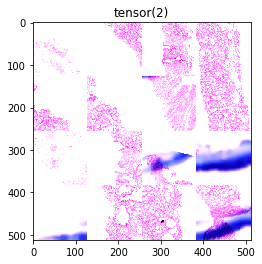

In [9]:
# test dataset
train_ds = MyDataset(train_df, 'train')
x, y = train_ds[2]
print(x.shape)
plt.imshow(x.permute(1, 2, 0).numpy())
plt.title(y)

In [11]:
train_ds = MyDataset(train_df, 'train')
train_dl = DataLoader(train_ds, batch_size=12, shuffle=True) # use 32 means 2 images per batch, don't shuffle to preserve 

val_ds = MyDataset(val_df, 'val')
val_dl = DataLoader(val_ds, batch_size=12, shuffle=True)

test_ds = MyDataset(test_df, 'val')
test_dl = DataLoader(test_ds, batch_size=12, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'tensor(0)')

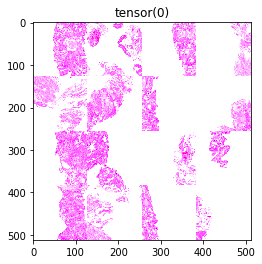

In [12]:
# test dl
x, y = next(iter(train_dl))
plt.imshow(x[0].permute(1, 2, 0).numpy())
plt.title(y[0])

# Model

In [13]:
# !pip install efficientnet-pytorch -q

In [15]:
from efficientnet_pytorch import EfficientNet

class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = EfficientNet.from_pretrained('efficientnet-b4')
        self.fc = nn.Linear(self.base._fc.out_features, 6)
        
    def forward(self, x):
        x = self.base(x)
        x = self.fc(x)
        x = nn.Softmax(dim=1)(x)
        
        return x

In [17]:
model = MyModel()
_ = model.to(device)
model.load_state_dict(torch.load('efn-3.pth', map_location=device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.) # traditional lr
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, verbose=1)

Loaded pretrained weights for efficientnet-b4


# Training

In [18]:
cohen_prev = np.ones(len(train_dl)) + 1

def train_on(epoch):
    # 
    torch.cuda.empty_cache()
    gc.collect()
    
    model.train(True)
    
    loss_epoch = []
    acc_epoch = []
    cohen_epoch = []
    for i, (x, y) in tqdm(enumerate(train_dl), total=len(train_dl)):
        x = x.to(device)
        y = y.to(device)
        
        y_preds = model(x)
        
        loss = nn.CrossEntropyLoss()(y_preds, y)
#         loss = nn.MSELoss()(nn.Softmax()(y_preds).argmax(axis=1), y) # combine the log softmax and one-hot
        acc = accuracy_score(y_preds.argmax(axis=1).cpu(), y.cpu())
        cohen = cohen_kappa_score(y_preds.argmax(axis=1).cpu(), y.cpu(), weights='quadratic')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print
#         if cohen_prev[i] == 2:
#             print('Epoch: %d, Step: %d, Loss: %2f, Acc: %2f, Cohen: %2f' % (epoch, i, loss, acc, cohen))
#         elif cohen > cohen_prev[i]:
#             print(colored('Epoch: %d, Step: %d, Loss: %2f, Acc: %2f, Cohen: %2f' % (epoch, i, loss, acc, cohen), 'green'))
#         elif cohen <= cohen_prev[i]:
#             print(colored('Epoch: %d, Step: %d, Loss: %2f, Acc: %2f, Cohen: %2f' % (epoch, i, loss, acc, cohen), 'red'))
#         cohen_prev[i] = cohen
        
        loss_epoch.append(loss.cpu().detach().numpy())
        acc_epoch.append(acc)
        cohen_epoch.append(cohen)
        
        del x, y, y_preds, loss
        torch.cuda.empty_cache()
        gc.collect()
        
    print(np.array(loss_epoch).mean(), np.array(acc_epoch).mean(), np.array(cohen_epoch).mean())
    return np.array(loss_epoch).mean(), np.array(acc_epoch).mean(), np.array(cohen_epoch).mean()
        

In [19]:
cohen_val_prev = np.ones(len(val_dl)) + 1

def val_on(epoch, dl):
    # 
    torch.cuda.empty_cache()
    gc.collect()
    
    model.eval()
    
    loss_epoch = []
    acc_epoch = []
    cohen_epoch = []
    cohen = None
    for i, (x, y) in tqdm(enumerate(dl), total=len(dl)):
        with torch.no_grad():
            x = x.to(device)
            y = y.to(device)
            
            y_preds = model(x)

            # get metrics
            loss = nn.CrossEntropyLoss()(y_preds, y)
            acc = accuracy_score(y_preds.argmax(axis=1).cpu().detach().numpy() , y.cpu().detach().numpy() )
            cohen = cohen_kappa_score(y_preds.argmax(axis=1).cpu().detach().numpy() , y.cpu().detach().numpy() , weights='quadratic')

            
            # print
#             if cohen_val_prev[i] == 2:
#                 print('Epoch: %d, Step: %d, Loss: %2f, Acc: %2f, Cohen: %2f' % (epoch, i, loss, acc, cohen))
#             elif cohen > cohen_val_prev[i]:
#                 print(colored('Epoch: %d, Step: %d, Loss: %2f, Acc: %2f, Cohen: %2f' % (epoch, i, loss, acc, cohen), 'green'))
#             elif cohen <= cohen_val_prev[i]:
#                 print(colored('Epoch: %d, Step: %d, Loss: %2f, Acc: %2f, Cohen: %2f' % (epoch, i, loss, acc, cohen), 'red'))
#             cohen_val_prev[i] = cohen
        
        
            loss_epoch.append(loss.cpu().detach().numpy())
            acc_epoch.append(acc)
            cohen_epoch.append(cohen)
        
        
            # clean
            del x, y, y_preds, loss, acc, cohen
            torch.cuda.empty_cache()
            gc.collect()
        
    print(np.array(loss_epoch).mean(), np.array(acc_epoch).mean(), np.array(cohen_epoch).mean())
    return np.array(loss_epoch).mean(), np.array(acc_epoch).mean(), np.array(cohen_epoch).mean()

In [20]:
def train(epochs):
    best_cohen = []
    for e in range(epochs):
        train_loss, train_acc, train_cohen = train_on(e)
        val_loss, val_acc, val_cohen = val_on(e, val_dl)
        
        scheduler.step(val_loss)
        
        # save best
        best_cohen.append(val_cohen)
        if val_cohen >= max(best_cohen):
            print('save best model')
            torch.save(model.state_dict(), 'efn.pth')

In [24]:
torch.cuda.empty_cache()
gc.collect()

20

In [ ]:
train(10)

In [ ]:
val_on(1, test_dl)

In [ ]:
!ls

In [ ]:
torch.save(model.state_dict(), './efn.pth')

In [ ]:
from IPython.display import FileLink
FileLink('./efn.pth')